In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold,cross_val_score
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.metrics import Recall
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Nadam,Adam
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras.constraints import maxnorm
import seaborn as sns
import kds

In [15]:
'''Pre-processing Section: In the code below I address preprocessing related concerns with the data
   and also split the data into test and training sets using an 80-20 split along with 
   addresing class imbalance'''
'''df: churn banking dataset
   credit_conditions: break down of credit score conditions
   credit_values: assigned descriptions for conditions
   age_conditions:break down of age conditions
   age_values: assigned descriptions for conditions
   '''
#read in churn dataset 
df=pd.read_csv("Churn_Modelling.csv")
#first five rows of dataset
df.head()
#description of the data
df.info()

# drop customer id and row number columns
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

# binning CreditScore column (based on equifax score ranges)

# define our conditions
credit_conditions = [
    (df['CreditScore'] >=300) &(df['CreditScore']<=579),
    (df['CreditScore'] >=580) & (df['CreditScore'] <= 669),
    (df['CreditScore'] >= 670) & (df['CreditScore'] <= 739),
    (df['CreditScore'] >= 740) & (df['CreditScore']<=799),
    (df['CreditScore'] >= 800) & (df['CreditScore']<=850)
    ]

# create a list of the values we want to assign for each condition
credit_values = ['Poor', 'Fair', 'Good', 'Very Good','Excellent']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Credit_Bins'] = np.select(credit_conditions, credit_values)

# one-hot encoding for credit bins
df=pd.get_dummies(prefix='Credit',data=df,columns=['Credit_Bins'],drop_first=True)


# define our conditions
age_conditions = [
    (df['Age'] >=0) &(df['Age']<=19),
    (df['Age'] >=20) & (df['Age'] <=34),
    (df['Age'] >= 35) & (df['Age'] <= 54),
    (df['Age'] >= 55) & (df['Age']<=64),
    (df['Age'] >= 65) & (df['Age']<=100)
    ]

# create a list of the values we want to assign for each condition
age_values = ['0-19', '20-34', '35-54', '55-64','65+']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Age_Bins'] = np.select(age_conditions, age_values)

#one-hot encoding for age bins
df = pd.get_dummies(prefix='Age',data=df,columns=['Age_Bins'],drop_first=True)

#remove original columns
df.drop(['Age','CreditScore'],inplace=True,axis=1)

# encode geographical feature
df=pd.get_dummies(prefix='Geo',data=df,columns=['Geography'],drop_first=True)

# numerically encode gender column
df=df.replace(to_replace={'Gender': {'Female': 1,'Male':0}})


# Partition data into training/test sets 

#define input data
X=df.drop('Exited',axis=1)
# define response
y=df['Exited']

#target distribution (highlighting imbalance)
print(y.value_counts(normalize=True))

# Partition data into training/test sets 
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42,shuffle=True)

# Standardization of training input data
scaler=RobustScaler()

#transformation
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

# Assign class weights to help handle imbalanced nature of target class
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y_train),
                                     y = y_train)

#assign weights to class labels wrapped as dictionary 
class_weights = dict(zip(np.unique(y_train), class_weights))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
0    0.7963
1    0.2037
Name: Exited, dtype: float64


In [93]:
'''Rule of Thumb Section: In this section we denote some of the rules of thumb learned earlier in the course 
   as it pertains to this specific project and how we can Identify possible starting values for neurons in the first 
   and second hidden layers (we can just use this as a reference)'''

'''m: number of outputs or classes
   N: number of features 
   first_layer: number of nodes in the first layer
   second_layer: number of nodes in the second layer
   input_neurons: number of input neurons
   output_neurons: 1
   samples_train: length of x training data
   alpha: arbitrary scaling factor
   hidden_layers: rule of thumb max number of hidden layers'''

# num outputs
m=2

#num features
N=17

# rule of thumb number of nodes first layer
first_layer=round((np.sqrt((m+2)*N)+2*np.sqrt((N/(m+2)))),0)

# rule of thumb number of nodes in second layer 
second_layer=round(m*np.sqrt((N/(m+2))),0)

# input neurons 
input_neurons=17

# output neurons 
output_neurons=1

#samples in training set 
samples_train=len(x_train)

# scaling factor 
alpha=2

#hidden layers constraint
hidden_layers=round(samples_train/(alpha*(input_neurons+output_neurons)),0)

In [76]:
'''Model Tuning Section: In the section below we construct our ANN via gridsearch in an effort to properly tune 
   the model'''

'''model: a feed forward model object
   batch_size: array of batch sizes to search over
   epochs: array of epochs required for training to search over
   learn_rate: array of learning rates, for our optimizer, to search over
   kernel_init: array of kernel initializers to search over
   activate: array of activation functions to search over
   weight_constraint: array of weights to search over for the kernel
   dropout_rate: array of drop out rates to search over 
   neurons1: neurons for first hidden layer to search over 
   neurons2: neurons for second hidden layer to search over'''



def create_model(dropout_rate=0.2,weight_constraint=2,
                 activate='relu',kernel_init='uniform',
                 learn_rate=0.001,optimizers='adam',
                 neurons1=12,
                 neurons2=4):
    '''this function allows us to create and finetune a feed-forward neural network model using a 3-fold cross-validated 
       approach'''
   
    
    #model object (sequential)
    model = Sequential()
    # first hidden layer
    model.add(Dense(units=neurons1, kernel_initializer=kernel_init, activation=activate,
                    kernel_constraint=maxnorm(weight_constraint),
                   input_dim=17))
    
    #dropout layer 
    model.add(Dropout(dropout_rate))
    # second hidden layer
    model.add(Dense(units=neurons2,kernel_initializer=kernel_init,activation=activate))
    
    #output layer
    model.add(Dense(1, kernel_initializer=kernel_init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learn_rate), metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model,verbose=0)
# define the grid search parameters

#batch sizes to search over
batch_size=[2,16,32,64,256] 
#epochs to search over
epochs=[50,100,400]

# learning rates to search over
learn_rate=[0.0001,0.001, 0.01, 0.1, 0.2, 0.3]
# kernel initializers to search over
kernel_init=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 
                    'glorot_uniform', 'he_normal', 'he_uniform']

# activation functions to search over
activate = ['softmax', 'softplus', 'softsign', 
              'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

# kernel weighted constraints to search over
weight_constraint = [1, 2, 3, 4, 5]
# dropout rates to search over
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# neurons in first and second hidden layers to search over
neurons1 = [1, 5, 10, 15, 20, 25, 30]
neurons2 = [1, 5, 10, 15, 20, 25, 30]


#defining our parameter grid
param_grid = dict(batch_size=batch_size,epochs=epochs,learn_rate=learn_rate,
                  kernel_init=kernel_init,
                  activate=activate,
                  weight_constraint=weight_constraint,dropout_rate=dropout_rate,
                  neurons1=neurons1,neurons2=neurons2)

#establishing our gridsearch object (3-fold cross validation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#fitting the gridsearch object 
grid_result = grid.fit(x_train,y_train,shuffle=True,class_weight=class_weights)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#mean test score
means = grid_result.cv_results_['mean_test_score']
# standard deviation score
stds = grid_result.cv_results_['std_test_score']
#parameters stored
params = grid_result.cv_results_['params']
#print out of mean, std and associated parameters
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\philf\Anaconda3\Conda File\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
C:\Users\philf\Anaconda3\Conda File\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\philf\Anaconda3\Conda File\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best: 0.839500 using {'neurons1': 15, 'neurons2': 20}
0.601201 (0.278550) with: {'neurons1': 1, 'neurons2': 1}
0.796250 (0.008228) with: {'neurons1': 1, 'neurons2': 5}
0.591150 (0.281998) with: {'neurons1': 1, 'neurons2': 10}
0.591150 (0.281998) with: {'neurons1': 1, 'neurons2': 15}
0.591150 (0.281998) with: {'neurons1': 1, 'neurons2': 20}
0.796250 (0.008228) with: {'neurons1': 1, 'neurons2': 25}
0.591150 (0.281998) with: {'neurons1': 1, 'neurons2': 30}
0.398799 (0.278550) with: {'neurons1': 5, 'neurons2': 1}
0.757505 (0.070503) with: {'neurons1': 5, 'neurons2': 5}
0.749002 (0.019482) with: {'neurons1': 5, 'neurons2': 10}
0.698640 (0.087340) with: {'neurons1': 5, 'neurons2': 15}
0.818001 (0.005944) with: {'neurons1': 5, 'neurons2': 20}
0.767877 (0.035809) with: {'neurons1': 5, 'neurons2': 25}
0.727997 (0.033267) with: {'neurons1': 5, 'neurons2': 30}
0.398799 (0.278550) with: {'neurons1': 10, 'neurons2': 1}
0.823872 (0.015346) with: {'neurons1': 10, 'neurons2': 5}
0.807878 (0.027410) wi

In [77]:
#batch size: 32, epochs 100   out of [2,16,32,64,256] and [50,100,400],Adam optimizer,
# out of ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
# learning rate of 0.01 out of [0.0001,0.001, 0.01, 0.1, 0.2, 0.3]

# he_normal is network weight initializer out of ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

# softmax activation function for layers one and two out of 

#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

#0.821999 using {'dropout_rate': 0.4, 'weight_constraint': 2} out of 
#weight_constraint = [1, 2, 3, 4, 5] and dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# {'neurons1': 15, 'neurons2': 20} out of neurons1 = [1, 5, 10, 15, 20, 25, 30] and neurons2 = [1, 5, 10, 15, 20, 25, 30]



In [94]:
'''Final Model Section: In the section below we define a function which outputs the final model constructed based on the 
   parameters found in the previous create_model function. We also utilize a K-fold cross validation along with fitting 
   the model to the training data'''

'''model: feed-forward model construct
   accuracies: 3-fold cross validated results for our model on the training set
   history: fitted final model object'''

def final_model(units=15,
                 units2=20,
                 input_dim=17):
    
    '''This function incorporates the tuned parameters found by using the create_model function'''
    #define feed-forward model 
    model = Sequential()
    #input layer and first hidden layer
    model.add(Dense(
    units=units,kernel_initializer='he_normal',
    activation='softmax',input_dim=input_dim,
    kernel_constraint=maxnorm(2)))
    
    #  Second hidden layer
    model.add(Dense(
    units=units2,kernel_initializer='he_normal',
    activation='softmax'))
    
    #Output layer
    model.add(Dense(
    units=1,kernel_initializer='he_normal',
    activation='sigmoid'))
    
    
    #compile model
    model.compile(optimizer=Adam(lr=0.01),
                 loss="binary_crossentropy",
                 metrics=["accuracy"])
    return model

# set a random seed for reproducibility
np.random.seed(42)
#create out final model 
model = KerasClassifier(build_fn=final_model, verbose=1,batch_size=32,epochs=100,
                       class_weight=class_weights)



# Evaluate neural network using three-fold cross-validation
accuracies=cross_val_score(model, x_train, y_train, cv=3)

#print mean accuracy across all three folds and associated standard deviation
print("Mean Accuracy: {}".format(accuracies.mean()))
print("Standard Deviation: {}".format(accuracies.std()))

#fit the final model
history=model.fit(x_train,y_train,validation_split=0.35,shuffle=True)

Epoch 1/100


C:\Users\philf\Anaconda3\Conda File\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
C:\Users\philf\Anaconda3\Conda File\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


167/167 [==============================] - 1s 2ms/step - loss: 0.6564 - accuracy: 0.7045
Epoch 2/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5781 - accuracy: 0.6936
Epoch 3/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5408 - accuracy: 0.7154
Epoch 4/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.7367
Epoch 5/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5051 - accuracy: 0.7495
Epoch 6/100
167/167 [==============================] - 0s 2ms/step - loss: 0.4991 - accuracy: 0.7476
Epoch 7/100
167/167 [==============================] - 0s 2ms/step - loss: 0.4934 - accuracy: 0.7600
Epoch 8/100
167/167 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.7465
Epoch 9/100
167/167 [==============================] - 0s 2ms/step - loss: 0.4900 - accuracy: 0.7628
Epoch 10/100
167/167 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.7540
E

C:\Users\philf\Anaconda3\Conda File\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


167/167 [==============================] - 1s 2ms/step - loss: 0.6671 - accuracy: 0.5875
Epoch 2/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5926 - accuracy: 0.6780
Epoch 3/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5635 - accuracy: 0.7124
Epoch 4/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5390 - accuracy: 0.7347
Epoch 5/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5234 - accuracy: 0.7484
Epoch 6/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5164 - accuracy: 0.7506
Epoch 7/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7545
Epoch 8/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5013 - accuracy: 0.7658
Epoch 9/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5008 - accuracy: 0.7562
Epoch 10/100
167/167 [==============================] - 0s 2ms/step - loss: 0.4956 - accuracy: 0.7622
E

C:\Users\philf\Anaconda3\Conda File\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


167/167 [==============================] - 1s 2ms/step - loss: 0.6545 - accuracy: 0.7274
Epoch 2/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5879 - accuracy: 0.6824
Epoch 3/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5532 - accuracy: 0.7235
Epoch 4/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5313 - accuracy: 0.7383
Epoch 5/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5189 - accuracy: 0.7473
Epoch 6/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5074 - accuracy: 0.7570
Epoch 7/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5027 - accuracy: 0.7557
Epoch 8/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7510
Epoch 9/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5007 - accuracy: 0.7467
Epoch 10/100
167/167 [==============================] - 0s 2ms/step - loss: 0.5020 - accuracy: 0.7439
E

Epoch 43/100
163/163 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.7631 - val_loss: 0.5256 - val_accuracy: 0.7318
Epoch 44/100
163/163 [==============================] - 0s 2ms/step - loss: 0.4872 - accuracy: 0.7663 - val_loss: 0.4705 - val_accuracy: 0.7671
Epoch 45/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7606 - val_loss: 0.5091 - val_accuracy: 0.7457
Epoch 46/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4821 - accuracy: 0.7575 - val_loss: 0.5357 - val_accuracy: 0.7239
Epoch 47/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4871 - accuracy: 0.7579 - val_loss: 0.4594 - val_accuracy: 0.7786
Epoch 48/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4845 - accuracy: 0.7637 - val_loss: 0.5119 - val_accuracy: 0.7411
Epoch 49/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4819 - accuracy: 0.7671 - val_loss: 0.5472 - val_accuracy:

Epoch 100/100
163/163 [==============================] - 0s 2ms/step - loss: 0.4732 - accuracy: 0.7687 - val_loss: 0.4606 - val_accuracy: 0.7736


In [105]:
history.model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 15)                270       
                                                                 
 dense_58 (Dense)            (None, 20)                320       
                                                                 
 dense_59 (Dense)            (None, 1)                 21        
                                                                 
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


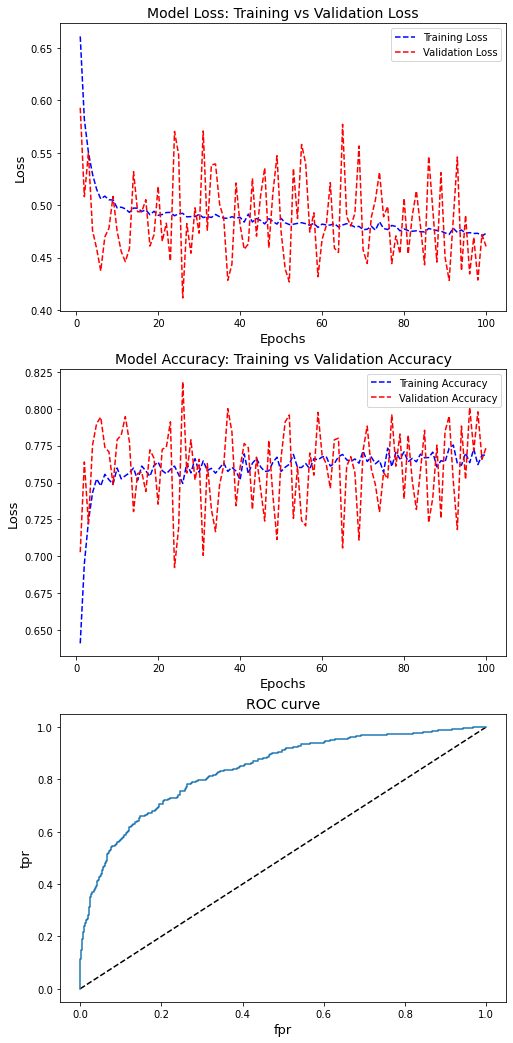

In [98]:
'''Visualization Section: In the section below we visualize model performance in terms of training vs validation accuracy,
training vs validation loss and the ROC-Curve'''

'''y_pred_proba: model predicted values
   fpr: false positive rate
   tpr: true positive rate
   thresholds: probability thresholds for classification
   acc: history of training accuracy
   val_acc: history of validation accuracy
   loss: history of training loss
   val_loss: history of validation loss
   epochs: epoch range
   '''


# model predicted values
y_pred_proba=history.model.predict(x_test)
# false positive rate, true positive rate, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# define subplots for plotting graphs
fig,ax=plt.subplots(3,1,figsize=(8,18))

#training accuracy
acc=history.history['accuracy']
#validation accuracy 
val_acc=history.history['val_accuracy']

#training loss 
loss=history.history['loss']
#validation loss
val_loss=history.history['val_loss']

#epoch range
epochs=list(np.arange(1,101))

# plot for training vs validation loss
ax[0].plot(epochs,loss,'--',label='Training Loss',color='blue')
ax[0].plot(epochs,val_loss,'--',label='Validation Loss',color='red')
ax[0].set_title('Model Loss: Training vs Validation Loss',fontsize=14)
ax[0].set_xlabel('Epochs',fontsize=13)
ax[0].set_ylabel('Loss',fontsize=13)

#plot for training vs validation accuracy
ax[1].plot(epochs,acc,'--',label='Training Accuracy',color='blue')
ax[1].plot(epochs,val_acc,'--',label='Validation Accuracy',color='red')
ax[1].set_title('Model Accuracy: Training vs Validation Accuracy',fontsize=14)
ax[1].set_xlabel('Epochs',fontsize=13)
ax[1].set_ylabel('Loss',fontsize=13)

#ROC curve plot 
ax[2].plot([0,1],[0,1],'k--')
ax[2].plot(fpr,tpr, label='ANN')
ax[2].set_xlabel('fpr',fontsize=13)
ax[2].set_ylabel('tpr',fontsize=13)
ax[2].set_title('ROC curve',fontsize=14)

ax[0].legend()
ax[1].legend()



plt.show()

Text(0.5, 15.0, 'Predicted label')

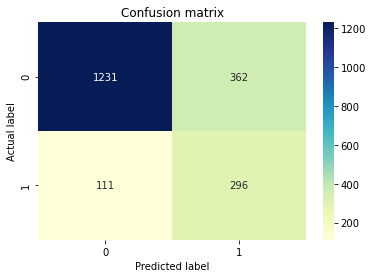

In [99]:
'''Metric Summary Section: In the section below we construct a confusion matrix for the model to examine its performance. 
   We also construct a classification report to get more specific information as well as produce test accuracy and loss
   results'''

'''y_pred: target predicted values
   cm: confusion matrix object
   p: seaborn object for our confusion matrix'''
# save target prediction values with .5 cuttoff in mind
y_pred = (y_pred_proba > 0.5)
# confusion matrix object creation
cm = confusion_matrix(y_test, y_pred)

# establish seaborn object for confusion matrix 
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# loss score on test data, accuracy score on test data
score, acc = history.model.evaluate(x_test,y_test)

# print outs of test score, accuracy and AUC as well as classification report
print()
print('Test score:',score)
print('Test accuracy:', acc)

print('AUC:',roc_auc_score(y_test,y_pred))
print()
print(classification_report(y_test,y_pred))

63/63 [==============================] - 0s 1ms/step
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of perc

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.799,0.996,0.899,200.0,150.0,50.0,40.7,200,75.0,200.0,150.0,200,50.0,10.0,36.855,49.14,3.139,33.716,3.686
1,2,0.665,0.799,0.737,200.0,84.0,116.0,40.7,200,42.0,400.0,234.0,400,166.0,20.0,57.494,98.28,10.421,47.073,2.875
2,3,0.532,0.665,0.595,200.0,53.0,147.0,40.7,7,26.5,600.0,287.0,407,313.0,30.0,70.516,100.00,19.648,50.868,2.351
3,4,0.416,0.532,0.477,200.0,37.0,163.0,40.7,0,18.5,800.0,324.0,407,476.0,40.0,79.607,100.00,29.881,49.726,1.990
4,5,0.310,0.415,0.360,200.0,25.0,175.0,40.7,0,12.5,1000.0,349.0,407,651.0,50.0,85.749,100.00,40.866,44.883,1.715
5,6,0.233,0.309,0.268,200.0,26.0,174.0,40.7,0,13.0,1200.0,375.0,407,825.0,60.0,92.138,100.00,51.789,40.349,1.536
6,7,0.169,0.232,0.198,200.0,13.0,187.0,40.7,0,6.5,1400.0,388.0,407,1012.0,70.0,95.332,100.00,63.528,31.804,1.362
7,8,0.119,0.169,0.144,200.0,8.0,192.0,40.7,0,4.0,1600.0,396.0,407,1204.0,80.0,97.297,100.00,75.581,21.716,1.216
8,9,0.071,0.119,0.093,200.0,5.0,195.0,40.7,0,2.5,1800.0,401.0,407,1399.0,90.0,98.526,100.00,87.822,10.704,1.095
9,10,0.016,0.071,0.052,200.0,6.0,194.0,40.7,0,3.0,2000.0,407.0,407,1593.0,100.0,100.000,100.00,100.000,0.000,1.000


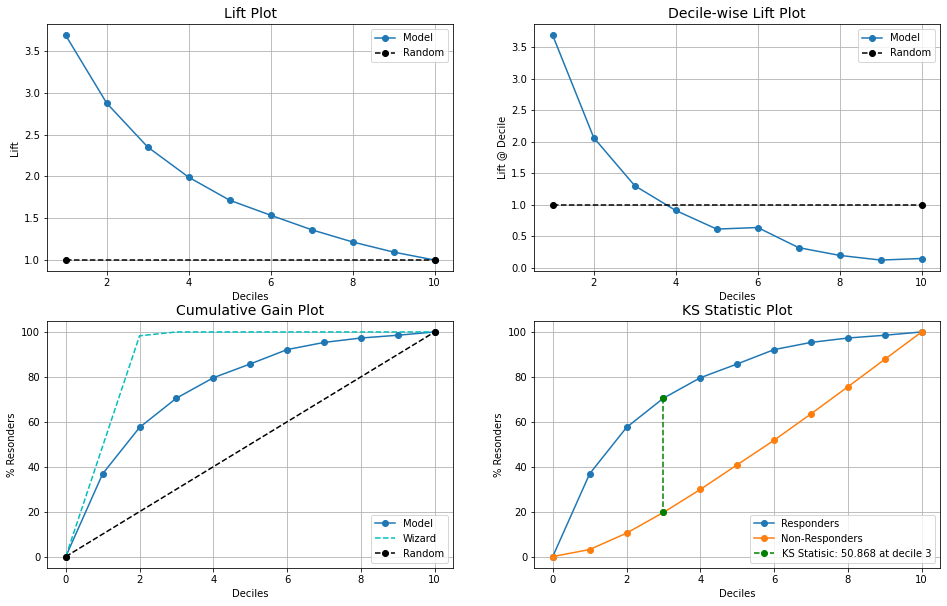

In [104]:
'''Decile Analysis Section: In the following section we conduct decile analysis which allows us to identify the top 
   deciles of customers most likely to churn and also the customers least likely to churn'''

'''Probabilities: associated target probabilities as predicted by our final model
   NN_df: a dataframe construct with the probabilities of churn and the associated decile rank as features'''

# target associated probabilities
probabilities=history.model.predict(x_test)

# dataframe construct with probabilities of churn as feature
NN_df=round(pd.DataFrame(np.amax(probabilities, axis=1), 
                         columns = ['prob_NN']),2)

# engineer decile rank feature
NN_df['Decile_rank']=pd.cut(NN_df['prob_NN'], 
                            10, labels = np.arange(10,0, -1))

# visualization of lift,decile cumulative gain and KS-statistic plots 
kds.metrics.report(y_test, probabilities)